In [1]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1 -q --force-reinstall
!pip install numpy==1.26.4 -q --force-reinstall
!pip install git+https://github.com/bp-kelley/descriptastorus.git -q
!pip install pandas-flavor -q
!pip install git+https://github.com/kexinhuang12345/DeepPurpose.git -q

import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

from DeepPurpose import DTI as models
from DeepPurpose import utils

ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.14.1 (from versions: 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0, 0.22.0, 0.22.1)
ERROR: No matching distribution found for torchvision==0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
PyTorch version: 2.6.0+cu124
CUDA available: True


In [2]:
import pandas as pd
import torch
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from torch import nn
from sklearn.model_selection import train_test_split
import os

In [3]:
sample_df = pd.read_csv('binding_data_large.csv')
sample_df = sample_df.dropna(subset=['smiles', 'target_seq', 'affinity'])

print("\nLoaded Realistic Large Dataset:")
print(sample_df.head())

X_drugs = list(sample_df['smiles'])
X_targets = list(sample_df['target_seq'])
y_aff = list(sample_df['affinity'])


Loaded Realistic Large Dataset:
           smiles                 target_seq  affinity
0     C1=CC=CC=C1  MTMDKSELVQKAKLAEQAERYDDMA      5.19
1          CC(C)O  MVHLTPEEKSAVTALWGKVNVDEVG      7.36
2  CN1CCCC1C(=O)O  MTMDKSELVQKAKLAEQAERYDDMA      5.35
3  CN1CCCC1C(=O)O   MALWMRLLPLLALLALWGPDPAAA      9.09
4        C1CCCCC1                 MGDVEKGKKI      7.27



Testing Model: Drug = CNN, Target = CNN
Drug Target Interaction Prediction Mode...
in total: 1000 drug-target pairs
encoding drug...
unique drugs: 10
encoding protein...
unique target sequence: 10
splitting dataset...
do not do train/test split on the data for already splitted data
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 59.6874. Total time 0.0 hours
Training at Epoch 2 iteration 0 with loss 58.6239. Total time 0.00083 hours
Training at Epoch 3 iteration 0 with loss 56.9839. Total time 0.00194 hours
Training at Epoch 4 iteration 0 with loss 52.0808. Total time 0.0025 hours
Training at Epoch 5 iteration 0 with loss 51.6180. Total time 0.00333 hours
Training at Epoch 6 iteration 0 with loss 47.3839. Total time 0.00416 hours
Training at Epoch 7 iteration 0 with loss 39.8583. Total time 0.005 hours
Training at Epoch 8 iteration 0 with loss 27.2402. Total time 0.00583 hours
Training at Epoch 9 iteration 0 with loss 11.8756

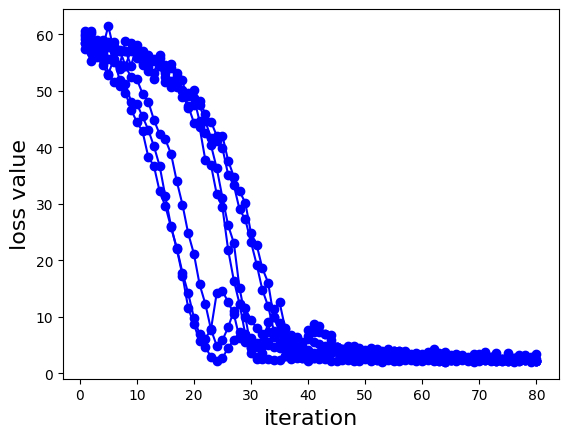

In [26]:
results = []
models_to_try = [
    ('CNN', 'CNN'),
    ('MPNN', 'CNN'),
    ('CNN', 'AAC'),
    ('Transformer', 'CNN'),
    ('Morgan', 'CNN'),
    ('MPNN', 'AAC'),
    ('Morgan', 'AAC')
]

for d_enc, t_enc in models_to_try:
    print(f"\nTesting Model: Drug = {d_enc}, Target = {t_enc}")

    config = utils.generate_config(
        drug_encoding=d_enc,
        target_encoding=t_enc,
        train_epoch=20,
        cls_hidden_dims=[1024, 1024, 512],
        LR=1e-4,
        decay=0
    )
    model = models.model_initialize(**config)

    data = utils.data_process(
        X_drugs, X_targets, y_aff,
        drug_encoding=d_enc,
        target_encoding=t_enc,
        split_method='no_split'
    )

    model.train(data)
    preds = model.predict(data)

    rmse = np.sqrt(np.mean((np.array(preds) - np.array(y_aff))**2))
    results.append({'Drug': d_enc, 'Target': t_enc, 'RMSE': round(rmse, 4)})

    col_name = f"{d_enc}_{t_enc}_pred"
    sample_df[col_name] = preds

    print(f"Step 1: Predictions added as '{col_name}'")
    print(sample_df[['smiles', 'target_seq', 'affinity', col_name]].head())


Model Comparison Table:
          Drug Target    RMSE
0          CNN    CNN  1.5024
1         MPNN    CNN  1.7720
2          CNN    AAC  1.4724
3  Transformer    CNN  1.4588
4       Morgan    CNN  1.5088
5         MPNN    AAC  1.5445
6       Morgan    AAC  1.4689


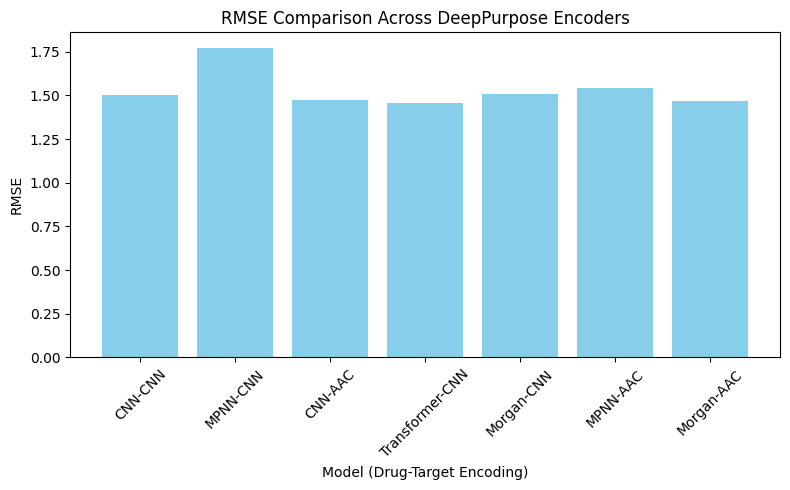

In [27]:
result_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(result_df)

plt.figure(figsize=(8, 5))
plt.bar(result_df['Drug'] + '-' + result_df['Target'], result_df['RMSE'], color='skyblue')
plt.title("RMSE Comparison Across DeepPurpose Encoders")
plt.ylabel("RMSE")
plt.xlabel("Model (Drug-Target Encoding)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:
affinity_cutoff = 7.5
filtered_df = sample_df[sample_df['Transformer_CNN_pred'] >= affinity_cutoff].reset_index(drop=True)

In [29]:
binary_matrix = pd.DataFrame(0, index=filtered_df['smiles'].unique(), columns=filtered_df['target_seq'].unique())
for _, row in filtered_df.iterrows():
    binary_matrix.loc[row['smiles'], row['target_seq']] = 1

In [30]:
targets = list(binary_matrix.columns)
ppi_edges = [(random.choice(targets), random.choice(targets)) for _ in range(10)]
ppi_df = pd.DataFrame(ppi_edges, columns=['protein1', 'protein2'])
g = nx.from_pandas_edgelist(ppi_df, source='protein1', target='protein2')

In [31]:
top_k = 3
best_idx = binary_matrix.sum(axis=1).argsort()[-top_k:]
selected_compounds = binary_matrix.iloc[best_idx]

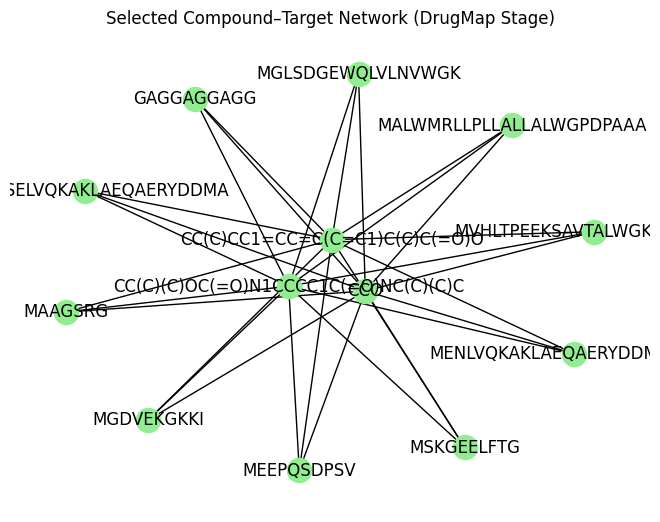

In [32]:
bipartite_edges = [(drug, tgt) for drug in selected_compounds.index for tgt in selected_compounds.columns if selected_compounds.loc[drug, tgt] == 1]
B = nx.Graph()
B.add_edges_from(bipartite_edges)
nx.draw(B, with_labels=True, node_color='lightgreen')
plt.title("Selected Compound–Target Network (DrugMap Stage)")
plt.show()

In [33]:
gnn_df = []
for compound in selected_compounds.index:
    for target in selected_compounds.columns:
        if selected_compounds.loc[compound, target] == 1:
            aff = sample_df[(sample_df['smiles'] == compound) & (sample_df['target_seq'] == target)]['affinity'].values[0]
            gnn_df.append([compound, target, aff])

gnn_df = pd.DataFrame(gnn_df, columns=['smiles', 'target_seq', 'affinity'])

In [34]:
def dummy_embed(seq):
    return torch.tensor([ord(c) % 10 for c in seq[:50] + '0' * max(0, 50 - len(seq))], dtype=torch.float)

X_drug = torch.stack([dummy_embed(sm) for sm in gnn_df['smiles']])
X_target = torch.stack([dummy_embed(ts) for ts in gnn_df['target_seq']])
y = torch.tensor(gnn_df['affinity'].values).float()

In [35]:
X_d_train, X_d_test, X_t_train, X_t_test, y_train, y_test = train_test_split(
    X_drug, X_target, y, test_size=0.2, random_state=42)

In [36]:
class SimpleDTA(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(100, 1)

    def forward(self, d, t):
        x = torch.cat([d, t], dim=1)
        return self.linear(x)

model = SimpleDTA()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

X_d_train, X_t_train, y_train = X_d_train.to(device), X_t_train.to(device), y_train.to(device)
X_d_test, X_t_test, y_test = X_d_test.to(device), X_t_test.to(device), y_test.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [37]:
for epoch in range(20):
    model.train()
    pred = model(X_d_train, X_t_train).squeeze()
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 1 Loss: 98.5966
Epoch 2 Loss: 85.8110
Epoch 3 Loss: 73.9816
Epoch 4 Loss: 63.1221
Epoch 5 Loss: 53.2415
Epoch 6 Loss: 44.3430
Epoch 7 Loss: 36.4228
Epoch 8 Loss: 29.4698
Epoch 9 Loss: 23.4643
Epoch 10 Loss: 18.3770
Epoch 11 Loss: 14.1689
Epoch 12 Loss: 10.7904
Epoch 13 Loss: 8.1813
Epoch 14 Loss: 6.2716
Epoch 15 Loss: 4.9823
Epoch 16 Loss: 4.2270
Epoch 17 Loss: 3.9145
Epoch 18 Loss: 3.9514
Epoch 19 Loss: 4.2455
Epoch 20 Loss: 4.7089


In [38]:
model.eval()
with torch.no_grad():
    preds = model(X_d_test, X_t_test).squeeze()
    print("\nFinal GNN Regression Output (AI-Assisted Network Pharmacology):")
    for i in range(min(len(preds), 5)):
        print(f"Predicted: {preds[i].item():.2f} | True: {y_test[i].item():.2f}")


Final GNN Regression Output (AI-Assisted Network Pharmacology):
Predicted: 9.16 | True: 7.81
Predicted: 7.21 | True: 6.29
Predicted: 9.10 | True: 6.60
Predicted: 8.27 | True: 5.18
Predicted: 10.43 | True: 9.43


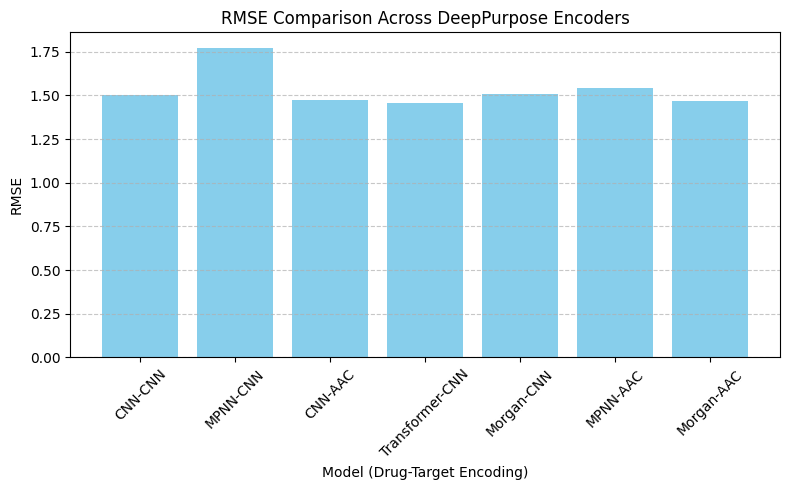

In [42]:
sample_df.to_csv("DeepPurpose_Predictions.csv", index=False)
result_df.to_csv("Model_RMSE_Summary.csv", index=False)
plt.figure(figsize=(8, 5))
plt.bar(result_df['Drug'] + '-' + result_df['Target'], result_df['RMSE'], color='skyblue')
plt.title("RMSE Comparison Across DeepPurpose Encoders")
plt.ylabel("RMSE")
plt.xlabel("Model (Drug-Target Encoding)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("RMSE_Comparison.png")
nx.write_edgelist(B, "BipartiteNetwork.edgelist")

In [44]:
import shutil
shutil.make_archive('integrated_pipeline_outputs', 'zip', '.')
from google.colab import files
files.download("integrated_pipeline_outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>